## Scénario
Vous êtes employé dans une banque, présente dans de nombreux pays à travers le monde. Celle-ci souhaite cibler de nouveaux clients potentiels, plus particulièrement les jeunes en âge d'ouvrir leur tout premier compte bancaire.

Cependant, elle souhaite cibler les prospects les plus susceptibles d'avoir, plus tard dans leur vie, de hauts revenus.

L'équipe dans laquelle vous travaillez a donc reçu pour mission de créer un modèle permettant de déterminer le revenu potentiel d'une personne.

Ainsi, vous proposez une régression linéaire avec 3 variables :

- le revenu des parents ;
- le revenu moyen du pays dans lequel habite le prospect ;
- l'indice de Gini calculé sur les revenus des habitants du pays en question.

# Mission 3

Dans l'état actuel, nous avons à disposition deux des trois variables explicatives souhaitées :

le revenu moyen du pays

l'indice de Gini du pays

Il nous manque donc, pour un individu, la classe de revenu de ses parents.

Nous allons donc simuler cette information grâce à un coefficient(propre à chaque pays), mesurant une corrélation entre le revenu de l'individu et le revenu de ses parents. Ce coefficient sera ici appelé coefficient d'élasticité ; il mesure la mobilité intergénérationnelle du revenu.

Le coefficient d'élasticité se calcul comme suit :
#### ln(Ychild) = α + ß1 ln(Yparent) + ϵ

Pour obtenir le coefficient d'élasticité, deux possibilités existe :
- Nous baser sur ces coefficients donnés par la Banque mondiale, dans GDIM dataset(https://www.worldbank.org/en/topic/poverty/brief/what-is-the-global-database-on-intergenerational-mobility-gdim). Le coefficient d'élasticité est donné pour certains pays, sous le nom d'IGE Income (relative IGM in income).


- Nous baser sur des estimations provenant de multiples études, extrapolées à différentes régions du monde :  elles se trouvent dans le fichier elasticity.txt. Attention, ces données sont parfois anciennes.

In [1]:
# Importation des librairies nécessaire à l'analyse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing, cluster, metrics, decomposition
from sklearn.cluster import KMeans
import scipy.stats as st
from collections import Counter
import plotly.express as px

#Paramètres de style de nos prochains graphique
plt.style.use('ggplot')

# Importation de mon dataframe de travail
df = pd.read_csv('df.csv')

# Visualisation du dataframe
df.head()

,country,country_code,year,quantile,nb_quantiles,income,gdpppp,population,gini,moyenne_income
0,Albania,ALB,2008,1,100,728.89795,7297.0,3002678.0,0.3,2994.829902
1,Albania,ALB,2008,2,100,916.66235,7297.0,3002678.0,0.3,2994.829902
2,Albania,ALB,2008,3,100,1010.91600,7297.0,3002678.0,0.3,2994.829902
3,Albania,ALB,2008,4,100,1086.90780,7297.0,3002678.0,0.3,2994.829902
4,Albania,ALB,2008,5,100,1132.69970,7297.0,3002678.0,0.3,2994.829902


In [2]:
# Importation de la base de donnée 'elasticity.csv'
elasticity = pd.read_csv('elasticity.txt', sep = '\t')[:16]
elasticity

,Coefficients of intergenerational elasticity between parents’ and
0,children’s income
1,| Base case | Optim...
2,| | (high...
3,----------------------------------------------...
4,Nordic European countries | 0.2 | ...
5,and Canada | | ...
6,----------------------------------------------...
7,Europe (except nordic | 0.4 | ...
8,countries) | | ...
9,----------------------------------------------...


Ce sont les chiffres de la ligne 4,7,10,12 et 14 qui vont nous aider à remplir les valeurs manquantes du dataframe 'classe_revenu'.

In [3]:
# Importation de la base de données de la Banque mondiale GDIM
classe_revenu = pd.read_csv('GDIMMay2018.csv')
classe_revenu.head(10)

,countryname,wbcode,iso3,region,incgroup2,incgroup4,fragile,survey,year,status,...,Cores2125_MAcatC1,Shortfall0611_obs,Shortfall0611_IGP,Shortfall1217_obs,Shortfall1217_IGP,IGEincome,S1,S2,S3,MLD_psu
0,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,25103.0,0.086197,18054.0,0.345224,NaN,NaN,NaN,NaN,0.1
1,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,12107.0,0.083271,8538.0,0.389952,NaN,NaN,NaN,NaN,0.1
2,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,12996.0,0.089161,9516.0,0.307687,NaN,NaN,NaN,NaN,0.1
3,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,25396.0,0.050447,18387.0,0.218062,NaN,NaN,NaN,NaN,0.1
4,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,12246.0,0.047961,8677.0,0.230909,NaN,NaN,NaN,NaN,0.1
5,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,13150.0,0.052881,9710.0,0.209336,NaN,NaN,NaN,NaN,0.1
6,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,25103.0,0.053183,18054.0,0.223265,NaN,NaN,NaN,NaN,0.1
7,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,12107.0,0.049939,8538.0,0.239690,NaN,NaN,NaN,NaN,0.1
8,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,12996.0,0.056296,9516.0,0.211123,NaN,NaN,NaN,NaN,0.1
9,Afghanistan,AFG,AFG,South Asia,Developing economies,Low income,1,NRVA,1980,Co-residents only,...,NaN,25475.0,0.066690,18427.0,0.258465,NaN,NaN,NaN,NaN,0.1


On remarque énormement de données manquantes pour la variable qui nous intéresse 'IGEincome'.

In [4]:
#Sélection des variables utiles
classe_revenu_df = classe_revenu[['countryname', 'iso3', 'region', 'IGEincome']].copy()

# Changement de noms des variables pour que ça puisse matcher avec notre dataframe de travail
classe_revenu_df.rename(columns={'countryname' : 'country', 'iso3' : 'country_code'}, inplace = True)

# Mise à l'écart des doublons dans notre dataframe
classe_revenu_df.drop_duplicates(inplace=True)
classe_revenu_df.drop_duplicates(subset=['country'], keep = 'last', inplace=True)

display(classe_revenu_df.head(10))
print(classe_revenu_df.shape)

,country,country_code,region,IGEincome
0,Afghanistan,AFG,South Asia,NaN
12,Angola,AGO,Sub-Saharan Africa,NaN
60,Albania,ALB,Europe & Central Asia,0.815874
84,Argentina,ARG,Latin America & Caribbean,NaN
99,Armenia,ARM,Europe & Central Asia,NaN
183,Australia,AUS,High income,0.275000
243,Austria,AUT,High income,0.245267
279,Azerbaijan,AZE,Europe & Central Asia,NaN
351,Belgium,BEL,High income,0.183176
405,Benin,BEN,Sub-Saharan Africa,0.855116


(150, 4)


150 pays sont représenter sur ce dataframe, voyons combien de valeurs manquantes il y a dans la variable 'IGEincome'.

In [5]:
# Vérification des valeurs manquantes dans mon dataframe
classe_revenu_missing = classe_revenu_df[classe_revenu_df['IGEincome'].isna()]
display(classe_revenu_missing.head())
classe_revenu_missing.shape

,country,country_code,region,IGEincome
0,Afghanistan,AFG,South Asia,NaN
12,Angola,AGO,Sub-Saharan Africa,NaN
84,Argentina,ARG,Latin America & Caribbean,NaN
99,Armenia,ARM,Europe & Central Asia,NaN
279,Azerbaijan,AZE,Europe & Central Asia,NaN


(77, 4)

In [6]:
#Identification des pays sans valeur pour la variable 'IGEincome'
missing_countries_gdim = classe_revenu_missing['country_code'].unique()
missing_countries_gdim = list(missing_countries_gdim)
len(missing_countries_gdim)

77

In [7]:
# Visualisation des region ou les valeurs sont manquantes
list(classe_revenu_missing['region'].unique())

['South Asia',
 'Sub-Saharan Africa',
 'Latin America & Caribbean',
 'Europe & Central Asia',
 'Middle East & North Africa',
 'High income',
 'East Asia & Pacific']

la région 'High Income' sont des pays considéré par la banque mondiale comme des pays avec des revenus élevés c-à-d des pays dont le revenu national brut par habitant dépasse 12 056 dollars. source : https://worldpopulationreview.com/country-rankings/high-income-countries

In [8]:
for valeur in missing_countries_gdim:
    if list(classe_revenu_df.loc[classe_revenu_df['country_code'] == valeur, 'region']) == ['South Asia']:
        classe_revenu_df.loc[classe_revenu_df['country_code'] == valeur, 'IGEincome'] = 0.50
    elif list(classe_revenu_df.loc[classe_revenu_df['country_code'] == valeur, 'region']) == ['Sub-Saharan Africa']:
        classe_revenu_df.loc[classe_revenu_df['country_code'] == valeur, 'IGEincome'] = 0.66
    elif list(classe_revenu_df.loc[classe_revenu_df['country_code'] == valeur, 'region']) == ['Latin America & Caribbean']:
        classe_revenu_df.loc[classe_revenu_df['country_code'] == valeur, 'IGEincome'] = 0.66
    elif list(classe_revenu_df.loc[classe_revenu_df['country_code'] == valeur, 'region']) == ['Europe & Central Asia']:
        classe_revenu_df.loc[classe_revenu_df['country_code'] == valeur, 'IGEincome'] = 0.40
    elif list(classe_revenu_df.loc[classe_revenu_df['country_code'] == valeur, 'region']) == ['East Asia & Pacific']:
        classe_revenu_df.loc[classe_revenu_df['country_code'] == valeur, 'IGEincome'] = 0.50
    else :
        classe_revenu_df.loc[classe_revenu_df['country_code'] == valeur, 'IGEincome'] = 0.40

Nous pouvons injecter la variable 'IGEincome' dans notre dataframe de travail.

In [9]:
# Injection de la variable 'IGEincome' dans notre dataframe de travail
df = df.merge(classe_revenu_df[['country_code', 'IGEincome']], how = 'left', on = 'country_code')
df.head(5)

,country,country_code,year,quantile,nb_quantiles,income,gdpppp,population,gini,moyenne_income,IGEincome
0,Albania,ALB,2008,1,100,728.89795,7297.0,3002678.0,0.3,2994.829902,0.815874
1,Albania,ALB,2008,2,100,916.66235,7297.0,3002678.0,0.3,2994.829902,0.815874
2,Albania,ALB,2008,3,100,1010.91600,7297.0,3002678.0,0.3,2994.829902,0.815874
3,Albania,ALB,2008,4,100,1086.90780,7297.0,3002678.0,0.3,2994.829902,0.815874
4,Albania,ALB,2008,5,100,1132.69970,7297.0,3002678.0,0.3,2994.829902,0.815874


In [10]:
# Vérification d'éventuelle valeur manquante
print(df['IGEincome'].isna().sum())

# Visulisation des pays ou il y a une valeur manquante
ige_missing = list(df[df['IGEincome'].isna()]['country'].unique())
print(ige_missing)

200
['Kosovo', 'Syrian Arab Republic']


Le Kosovo à des valeurs manquantes dans la variable 'IGEincome' le pays est situé en Europe du Sud ce qui équivaut à une valeur de => 0.40


La Syrie est un pays situé en Asie de l'Ouest ce qui équivaut à une valeur de => 0.50

In [11]:
# Injection des valeurs dites ci-dessus dans notre dataframe de travail
for country in ige_missing:
    if list(df.loc[df['country'] == "Kosovo"]):
        df.loc[df['country'] == country, 'IGEincome'] = 0.40
    else :
        df.loc[df['country'] == country, 'IGEincome'] = 0.50

In [12]:
# Vérification de valeur manquantes dans notre dataframe de travail
df.isna().any()

country           False
country_code      False
year              False
quantile          False
nb_quantiles      False
income            False
gdpppp            False
population        False
gini              False
moyenne_income    False
IGEincome         False
dtype: bool

Notre dataframe de travail à été complété avec succés, nous avons nos 3 variables utiles au calcul des différentes classes de revenu des parents :
- L'Income moyen de chaque pays(gini)
- L'Indice de Gini de chaque pays(moyenne_income)
- Le coefficient d'élasticité pour chaque pays(IGEincome)

## Calcul des différentes classes de revenus

### 1) Création des revenues des parents selon une loi normale (d'une moyenne 0 et d'un écart-type de 1)

Le revenu des parents (exprimés en log) est géneré aléatoirement selon une loi normale. Le choix de la moyenne et de l'écart type n'auront pas d'incidence sur le résultat final. n doit être supérieur à 1000 fois le nombre de quantiles.

In [13]:
pj = 0.33 # Nous prenons comme exemple la France qui à un coefficient d'élasticité de 0.33
nb_quantiles = 100 # Ce nombre représente le nombre de quantiles dans notre échantillon
n = 1000 * nb_quantiles # n et égal à 1000 fois le nombre de quantiles

In [14]:
# On génère les revenus des parents (exprimés en logs) selon une loi normale.
# La moyenne et variance n'ont aucune incidence sur le résultat final (ie. sur le caclul de la classe de revenu)
# la fonction '.norm()' va générer une distribution normale aléatoire
ln_y_parent = st.norm(0,1).rvs(size=n) # la méthode 'rvs()' va indiquer le nombre de valeur à generer

### 2) réalisations du terme d'erreur ϵ selon une loi normale de moyenne 0 et d'écart type 1.

Génération aléatoire d'epsilon

In [15]:
# Génération d'une réalisation du terme d'erreur epsilon
residues = st.norm(0,1).rvs(size=n)

### 3) Calcule de Y_child(revenus des enfants)

Le calcul du revenus de l'enfant avec un coefficient d'élasticité (ici 0.33, par défaut celui de la France), le nombre alpha n'est pas pris en compte dans ce calcul et 'y_child' a des valeurs dont l'ordre de grandeur ne reflète pas la réalité mais qui n'aura aucune incidence sur la suite.

In [16]:
# Création d'une fonction qui va calculer le revenus des enfants
def generate_incomes(n, pj):
    return np.exp(pj*ln_y_parent + residues), np.exp(ln_y_parent)

# Stockage des résultats obtenues
y_child, y_parents = generate_incomes(n, pj)

### 4) Calcul de la classe de revenu de 'c_i_child' ainsi que la classe de revenu de ses parents 'c_i_parents' pour chaque individus 'n'

In [17]:
def quantiles(l, nb_quantiles):
    size = len(l) # size = 100 000
    l_sorted = l.copy()
    l_sorted = l_sorted.sort_values() # rangement par ordre croissant des valeurs de ma series
    # arange => suite de nombre qui va de 1 et qui va aller jusqu'à 101 par petit pas de 0.001, au total 100 000 rows
    quantiles = np.round(np.arange(1, nb_quantiles+1, nb_quantiles/size) -0.5 +1.00/size) # round => 
    q_dict = {a:int(b) for a,b in zip(l_sorted,quantiles)} # Association des valeurs de 'l_sorted' avec 'quantiles' dans l'ordre de ces derniers
    return pd.Series([q_dict[e] for e in l]) # q_dict[e] =>

def compute_quantiles(y_child, y_parents, nb_quantiles):
    y_child = pd.Series(y_child)
    y_parents = pd.Series(y_parents) # transformation des narray en dataframe avec un index
    c_i_child = quantiles(y_child, nb_quantiles) 
    c_i_parent = quantiles(y_parents, nb_quantiles) # Utilisation de la fonction 'quantiles' qui va =>
    sample = pd.concat([y_child, y_parents, c_i_child, c_i_parent], axis=1) # Création d'un dataframe avec les valeurs obtenus de notre fonction 'quantiles'
    sample.columns = ["y_child", "y_parents", "c_i_child","c_i_parent"] # Changement de nom des colonnes dans notre dataframe
    return sample

# Instantition de notre fonction 'compute_quantiles'
sample = compute_quantiles(y_child, y_parents, nb_quantiles)

In [18]:
# Visualisation de notre résultats
display(sample.head())
sample.shape

,y_child,y_parents,c_i_child,c_i_parent
0,1.163676,1.169700,56,57
1,1.761297,11.194971,71,100
2,1.928682,1.317211,74,61
3,0.480080,0.186580,25,5
4,7.356730,6.455159,98,97


(100000, 4)

### 5) Estimation de la distribution conditionnelle de 'c_i_child' & 'c_i_parents'

In [19]:
# Utilisation des fonctions de distribution et de probabilité conditionnelles
def distribution(counts, nb_quantiles):
    distrib = []
    total = counts["counts"].sum()
    
    if total == 0 :
        return [0] * nb_quantiles
    
    for q_p in range(1, nb_quantiles+1):
        subset = counts[counts.c_i_parent == q_p]
        if len(subset):
            nb = subset["counts"].values[0]
            distrib += [nb / total]
        else:
            distrib += [0]
    return distrib   

def conditional_distributions(sample, nb_quantiles):
    counts = sample.groupby(["c_i_child","c_i_parent"]).apply(len)
    counts = counts.reset_index()
    counts.columns = ["c_i_child","c_i_parent","counts"]
    
    mat = []
    for child_quantile in np.arange(nb_quantiles)+1:
        subset = counts[counts.c_i_child == child_quantile]
        mat += [distribution(subset, nb_quantiles)]
    return np.array(mat)

def proba_cond(c_i_parent, c_i_child, mat):
    return mat[c_i_child, c_i_parent]

cd = conditional_distributions(sample, nb_quantiles)

In [20]:
# Visualisation rapide de notre variable 'cd'
print(cd.shape)
list(cd)

(100, 100)


[array([0.061, 0.044, 0.042, 0.032, 0.035, 0.026, 0.026, 0.026, 0.02 ,
        0.025, 0.02 , 0.019, 0.014, 0.008, 0.03 , 0.02 , 0.017, 0.012,
        0.015, 0.016, 0.02 , 0.017, 0.015, 0.018, 0.021, 0.014, 0.016,
        0.015, 0.008, 0.015, 0.007, 0.01 , 0.004, 0.008, 0.008, 0.009,
        0.013, 0.006, 0.007, 0.009, 0.011, 0.004, 0.01 , 0.008, 0.005,
        0.01 , 0.015, 0.007, 0.007, 0.007, 0.007, 0.008, 0.01 , 0.004,
        0.007, 0.007, 0.004, 0.007, 0.003, 0.005, 0.004, 0.004, 0.004,
        0.006, 0.   , 0.004, 0.006, 0.005, 0.005, 0.005, 0.005, 0.005,
        0.005, 0.006, 0.   , 0.003, 0.003, 0.003, 0.001, 0.001, 0.001,
        0.008, 0.002, 0.002, 0.002, 0.001, 0.004, 0.001, 0.002, 0.001,
        0.   , 0.002, 0.002, 0.   , 0.   , 0.001, 0.001, 0.   , 0.001,
        0.   ]),
 array([0.047, 0.031, 0.041, 0.015, 0.024, 0.021, 0.022, 0.013, 0.017,
        0.018, 0.023, 0.024, 0.021, 0.019, 0.018, 0.012, 0.013, 0.017,
        0.021, 0.015, 0.019, 0.017, 0.01 , 0.013, 0.013, 0.0

### 6) Visualisation des distribution conditionnelles

#### Pour vérifier la cohérence de notre code, nous allons créer un graphique représentant ces distributions conditionnelles

Voici un premier exemple représentant une forte mobilité(0.1) :

In [21]:
def plot_conditional_distributions_fort(p, cd, nb_quantiles):
    plt.figure(figsize=(10, 8))
    
    # La ligne suivante sert à afficher un graphique en "stack bars", sur ce modèle : https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
    cumul = np.array([0] * nb_quantiles)
    
    for i, child_quantile in enumerate(cd):
        plt.bar(np.arange(nb_quantiles)+1, child_quantile, bottom=cumul, width=0.95, label = str(i+1) +"e")
        cumul = cumul + np.array(child_quantile)

    plt.axis([.5, nb_quantiles*1.3 ,0 ,1])
    plt.title("Forte mobilité " + "p=" + str(p), fontsize = 15, fontweight='bold')
    plt.legend()
    plt.xlabel("quantile parents", fontsize = 10, fontweight='bold')
    plt.ylabel("probabilité du quantile enfant", fontsize = 10, fontweight='bold')
    
    plt.savefig('Graphs/forte_mobilité_0.1.png')
    plt.show()

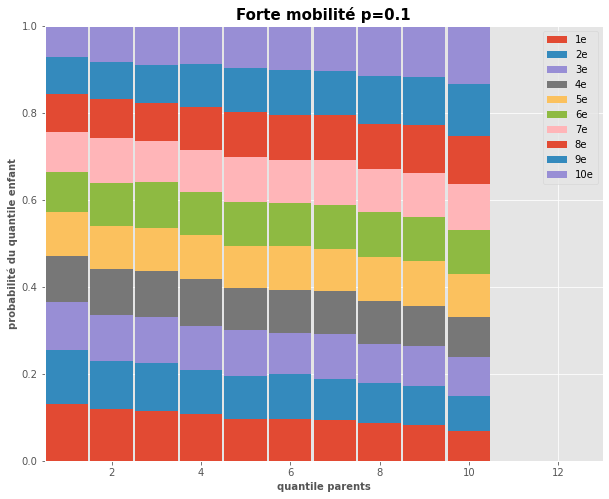

In [22]:
# Injection des différents paramètre pour avoir une forte mobilité(0.1)
pj_forte = 0.1
nb_quantiles_fort = 10
n_fort = 1000 * nb_quantiles_fort

y_child_fort, y_parents_fort = generate_incomes(n_fort, pj_forte)
sample_fort = compute_quantiles(y_child_fort, y_parents_fort, nb_quantiles_fort)
cd_fort = conditional_distributions(sample_fort, nb_quantiles_fort)
plot_conditional_distributions_fort(pj_forte, cd_fort, nb_quantiles_fort)

Avec une forte mobilité intergénérationelle les enfants de parents de chaque classes de revenus ont autant de chance de mobilité les uns des autres pour changer de classe. En d'autre termes les enfants ont autant de chance que les autres de changer de classe de revenus auquel appartiennent leurs parents.

Voici un deuxième exemple représentant une faible mobilité(0.9) :

In [23]:
def plot_conditional_distributions_faible(p, cd, nb_quantiles):
    plt.figure(figsize=(10, 8))
    
    # La ligne suivante sert à afficher un graphique en "stack bars", sur ce modèle : https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
    cumul = np.array([0] * nb_quantiles)
    
    for i, child_quantile in enumerate(cd):
        plt.bar(np.arange(nb_quantiles)+1, child_quantile, bottom=cumul, width=0.95, label = str(i+1) +"e")
        cumul = cumul + np.array(child_quantile)

    plt.axis([.5, nb_quantiles*1.3 ,0 ,1])
    plt.title("Faible mobilité " + "p=" + str(p), fontsize = 15, fontweight='bold')
    plt.legend()
    plt.xlabel("quantile parents", fontsize = 10, fontweight='bold')
    plt.ylabel("probabilité du quantile enfant", fontsize = 10, fontweight='bold')
    
    plt.savefig('Graphs/faible_mobilité_0.9.png')
    plt.show()

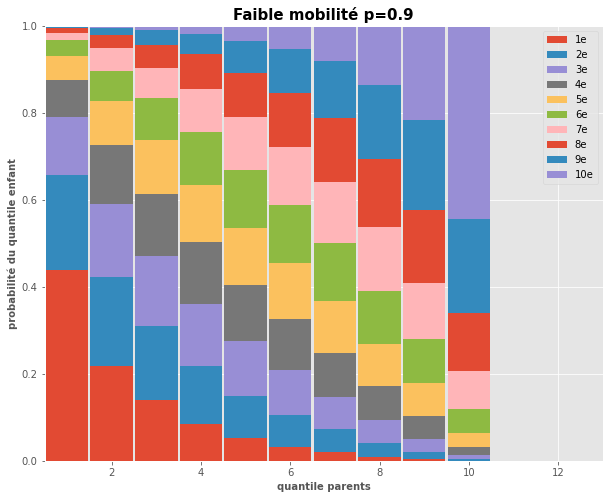

In [24]:
# Injection des différents paramètre pour avoir une faible mobilité(0.9)
pj_faible = 0.9
nb_quantiles_faible = 10
n_faible = 1000 * nb_quantiles_faible

y_child_faible, y_parents_faible = generate_incomes(n_fort, pj_faible)
sample_faible = compute_quantiles(y_child_faible, y_parents_faible, nb_quantiles_faible)
cd_faible = conditional_distributions(sample_faible, nb_quantiles_faible)
plot_conditional_distributions_faible(pj_faible, cd_faible, nb_quantiles_faible)

À l'inverse du premier exemple, dans une situation de faible mobilité intergénérationnelle que les enfants issu de la 10ème classe parents pour laquelle il y a moins de 50% de mobilité chez les enfants, en d'autres termes les enfants resteront majoritairement dans la classe de revenu de leurs parents.

### 7) Effacement des individus, quen nous venons de générer (nous n'en avons plus besoin).

In [25]:
# Mise à l'écart des deux premières variables du dataframe 'sample'
sample = sample.iloc[:, 2:]
sample.head()

,c_i_child,c_i_parent
0,56,57
1,71,100
2,74,61
3,25,5
4,98,97


### 8) Création d'un dataframe 500 fois plus grand que l'échantillon de la WID(World Income Distribution)

In [26]:
# Création d'une copy de notre dataframe de travail
df_wid = df.copy()

# Création de 499 clones de nos valeurs au sein de notre dataframe
df_wid500 = pd.concat([df_wid] * 500, ignore_index = True)
display(df_wid500.head())
df_wid500.shape

,country,country_code,year,quantile,nb_quantiles,income,gdpppp,population,gini,moyenne_income,IGEincome
0,Albania,ALB,2008,1,100,728.89795,7297.0,3002678.0,0.3,2994.829902,0.815874
1,Albania,ALB,2008,2,100,916.66235,7297.0,3002678.0,0.3,2994.829902,0.815874
2,Albania,ALB,2008,3,100,1010.91600,7297.0,3002678.0,0.3,2994.829902,0.815874
3,Albania,ALB,2008,4,100,1086.90780,7297.0,3002678.0,0.3,2994.829902,0.815874
4,Albania,ALB,2008,5,100,1132.69970,7297.0,3002678.0,0.3,2994.829902,0.815874


(5800000, 11)

### 9) Injection des classes parents à chaque individus dans notre échantillon

In [27]:
def generate_incomes9(n, pj):
    # On génère les revenus des parents (exprimés en logs) selon une loi normale.
    # La moyenne et variance n'ont aucune incidence sur le résultat final (ie. sur le caclul de la classe de revenu)
    ln_y_parent = st.norm(0,1).rvs(size=n)
    # Génération d'une réalisation du terme d'erreur epsilon
    residues = st.norm(0,1).rvs(size=n)
    return np.exp(pj*ln_y_parent + residues), np.exp(ln_y_parent)
    
def quantiles9(l, nb_quantiles):
    size = len(l)
    l_sorted = l.copy()
    l_sorted = l_sorted.sort_values()
    quantiles = np.round(np.arange(1, nb_quantiles+1, nb_quantiles/size) -0.5 +1./size)
    q_dict = {a:int(b) for a,b in zip(l_sorted,quantiles)}
    return pd.Series([q_dict[e] for e in l])

def compute_quantiles9(y_child, y_parents, nb_quantiles):
    y_child = pd.Series(y_child)
    y_parents = pd.Series(y_parents)
    c_i_child = quantiles(y_child, nb_quantiles)
    c_i_parent = quantiles(y_parents, nb_quantiles)
    sample = pd.concat([y_child, y_parents, c_i_child, c_i_parent], axis=1)
    sample.columns = ["y_child", "y_parents", "c_i_child","c_i_parent"]
    return sample

In [28]:
# Sélection et changement de nom des variables utiles au calcul de la classe de revenus des parents
df_wid500.rename(columns={'gini': 'Gj', 'IGEincome': 'pj'}, inplace=True)
df_wid500_copy = df_wid500[['country', 'country_code', 'quantile', 'income', 'Gj', 'pj']].copy()

In [29]:
nb_quantiles = 100       # nombre de quantiles (nombre de classes de revenu)
n  = len(df_wid500_copy) # taille de l'échantillon
ln_y_parent = st.norm(0,1).rvs(size=n)
residus = st.norm(0,1).rvs(size=n)

distrib_pays2 = pd.concat([
    pd.DataFrame(list(zip(ln_y_parent, residus)), columns=['ln_y_parent','residus']), 
    df_wid500_copy], axis=1)

# Génération aléatoire des revenus des parents et des enfants suivant une loi normale
y_child, y_parents = generate_incomes9(n, pj)

# Création des quantiles selon le revenus 'y_child' & 'y_parent'
sample = compute_quantiles9(y_child, y_parents, nb_quantiles)

# Injection du dataframe 'sample' dans notre dataframe 'df_wid500_copy'
df_wid500_copy['y_child'] = sample['y_child']
df_wid500_copy['y_parents'] = sample['y_parents']
df_wid500_copy['c_i_child'] = sample['c_i_child']
df_wid500_copy['c_i_parent'] = sample['c_i_parent']

# Visualisation de notre dataframe
df_wid500_copy.head()

,country,country_code,quantile,income,Gj,pj,y_child,y_parents,c_i_child,c_i_parent
0,Albania,ALB,1,728.89795,0.3,0.815874,7.911652,0.342861,98,15
1,Albania,ALB,2,916.66235,0.3,0.815874,9.166959,1.251545,99,59
2,Albania,ALB,3,1010.91600,0.3,0.815874,0.139889,2.554913,4,83
3,Albania,ALB,4,1086.90780,0.3,0.815874,2.310278,1.772639,79,72
4,Albania,ALB,5,1132.69970,0.3,0.815874,0.507307,0.747888,26,39


### 10) Suppréssion de la variable 'c_i_child'

In [30]:
# Suppression de la variable c_i_child inutile pour la mission 4
df_wid500_copy.drop(columns='c_i_child', inplace=True)

### 11) Ajout de la variable 'mj'(income_moyen) dans notre dataset pour effectuer la mission 4

In [31]:
# Aggrégation de notre dataframe par pays et utilisation de la fonction 'mean()' pour connaitre la moyenne de nos variable quantitative
df_wid500_copy_mean = distrib_pays2.groupby(['country']).mean()

# Ajout d'un nouvel index pour notre dataframe
df_wid500_copy_mean.reset_index(inplace = True)

# Sélection des variables utiles à la jointure
df_wid500_copy_mean = df_wid500_copy_mean[['country', 'income']]

# Changement de nom pour la variable 'y_child'
df_wid500_copy_mean.rename(columns={'income' : 'mj'}, inplace = True)

In [32]:
# Ajout de la variable 'mj' dans notre dataframe 'df_wid500_copy'
df_wid500_copy = pd.merge(df_wid500_copy_mean, df_wid500_copy, how = 'left', on = 'country')
display(df_wid500_copy.head())
print(df_wid500_copy.shape)

,country,mj,country_code,quantile,income,Gj,pj,y_child,y_parents,c_i_parent
0,Albania,2994.829902,ALB,1,728.89795,0.3,0.815874,7.911652,0.342861,15
1,Albania,2994.829902,ALB,2,916.66235,0.3,0.815874,9.166959,1.251545,59
2,Albania,2994.829902,ALB,3,1010.91600,0.3,0.815874,0.139889,2.554913,83
3,Albania,2994.829902,ALB,4,1086.90780,0.3,0.815874,2.310278,1.772639,72
4,Albania,2994.829902,ALB,5,1132.69970,0.3,0.815874,0.507307,0.747888,39


(5800000, 10)


In [33]:
# Enregistrement de notre dataframe pour la mission 4
df_wid500_copy.to_csv('df_mission4.csv', index = False)